In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

In [3]:
random.seed(760)

In [4]:
data=pd.read_csv('drive/MyDrive/clean_data.csv', encoding='utf-8')
def get_season(month): #春0夏1秋2冬3
    if 9 <= month <= 11:
        return "0"
    elif 12 <= month <= 2:
        return "1"
    elif 3 <= month <= 6:
        return "2"
    else:
        return "3"
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data['Date'].dt.month.apply(get_season)
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()
grouped_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

In [5]:
selected_age = ['Teenagers', 'Middle-aged-young', 'Middle-aged-old', 'Elderly']
filtered_data = data[data['Age Group'].isin(selected_age)]
crime_counts_by_age = filtered_data.groupby(['Date', 'Age Group'])['Victimisations'].sum().reset_index()

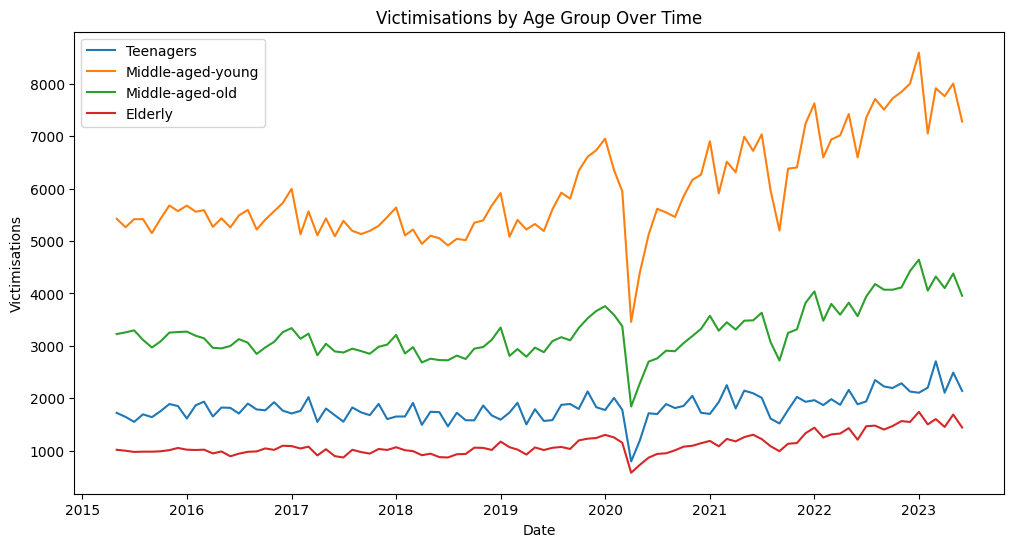

In [6]:
crime_counts_by_age['Date'] = pd.to_datetime(crime_counts_by_age['Date'])
crime_counts_by_age.sort_values(['Date', 'Age Group'], inplace=True)
plt.figure(figsize=(12, 6))
for age_group in selected_age:
    subset = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    plt.plot(subset['Date'], subset['Victimisations'], label=age_group)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Age Group Over Time')
plt.legend()
plt.show()

In [7]:
selected_type = ['Theft and Related Offences', 'Acts Intended to Cause Injury', 'Sexual Assault and Related Offences', 'Robbery, Extortion and Related Offences','Unlawful Entry With Intent/Burglary, Break and Enter','Abduction, Harassment and Other Related Offences Against a Person']
filtered_data = data[data['ANZSOC Division'].isin(selected_type)]
crime_counts_by_type = filtered_data.groupby(['Date', 'ANZSOC Division'])['Victimisations'].sum().reset_index()

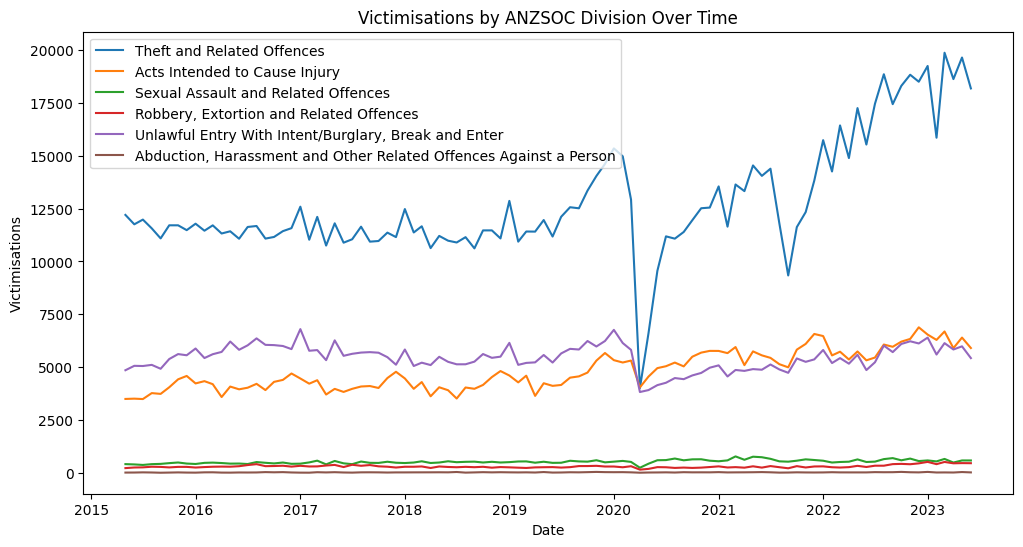

In [8]:
crime_counts_by_type['Date'] = pd.to_datetime(crime_counts_by_type['Date'])
crime_counts_by_type.sort_values(['Date', 'ANZSOC Division'], inplace=True)
plt.figure(figsize=(12, 6))
for type_group in selected_type:
    subset = crime_counts_by_type[crime_counts_by_type['ANZSOC Division'] == type_group]
    plt.plot(subset['Date'], subset['Victimisations'], label=type_group)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by ANZSOC Division Over Time')
plt.legend()
plt.show()

In [9]:
selected_ethnicities = ['Asian', 'European', 'Indian', 'Maori', 'Pacific Island']
filtered_data = data[data['Ethnic Group'].isin(selected_ethnicities)]
crime_counts_by_ethnicity = filtered_data.groupby(['Date', 'Ethnic Group'])['Victimisations'].sum().reset_index()

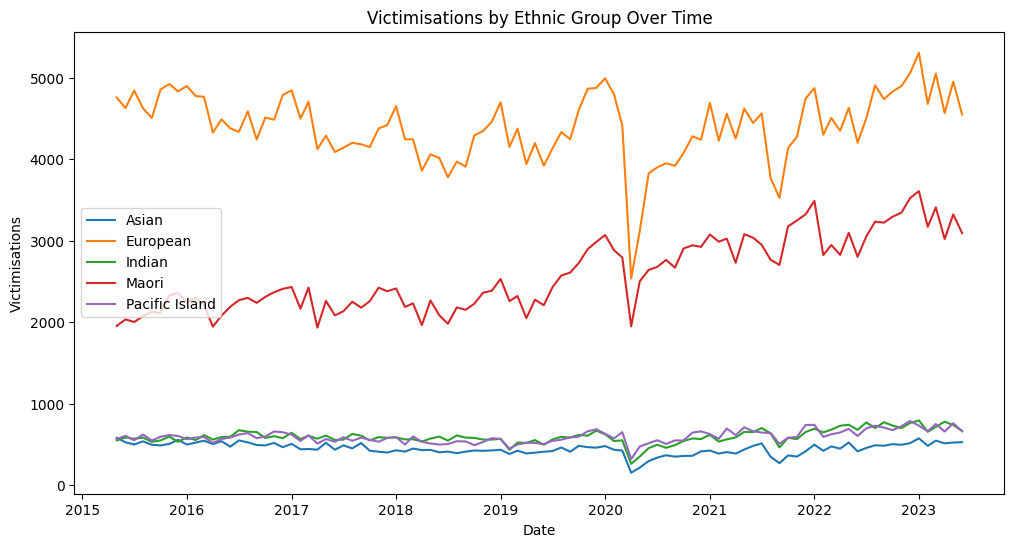

In [10]:
crime_counts_by_ethnicity['Date'] = pd.to_datetime(crime_counts_by_ethnicity['Date'])
crime_counts_by_ethnicity.sort_values(['Date', 'Ethnic Group'], inplace=True)
plt.figure(figsize=(12, 6))
for ethnicity in selected_ethnicities:
    subset = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    plt.plot(subset['Date'], subset['Victimisations'], label=ethnicity)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Ethnic Group Over Time')
plt.legend()
plt.show()

In [11]:
train_data = grouped_data[grouped_data['Date'] < '2021-01-01']
test_data = grouped_data[grouped_data['Date'] >= '2021-01-01']

In [12]:
scaler = MinMaxScaler()
grouped_data_scaled = scaler.fit_transform(grouped_data[['Victimisations', 'season']])
train_data_scaled = grouped_data_scaled[grouped_data['Date'] < '2021-01-01']
test_data_scaled = grouped_data_scaled[grouped_data['Date'] >= '2021-01-01']

In [13]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

In [14]:
def train_and_predict_LSTM(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stop = EarlyStopping(monitor='val_loss', patience=20)
    model.fit(X_train[:, :, np.newaxis], y_train, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])
    predicted = model.predict(X_test[:, :, np.newaxis])
    return predicted

Epoch 1/200
14/14 [==============================] - 9s 84ms/step - loss: 0.2586 - val_loss: 0.1087
Epoch 2/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0287 - val_loss: 0.0957
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0185 - val_loss: 0.1021
Epoch 4/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0120 - val_loss: 0.0956
Epoch 5/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0988
Epoch 6/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0124 - val_loss: 0.0943
Epoch 7/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0113 - val_loss: 0.1009
Epoch 8/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0121 - val_loss: 0.0984
Epoch 9/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0121 - val_loss: 0.0956
Epoch 10/200
14/14 [==============================] - 0s 18ms/step - loss: 0.0092 - val_loss: 0.0971

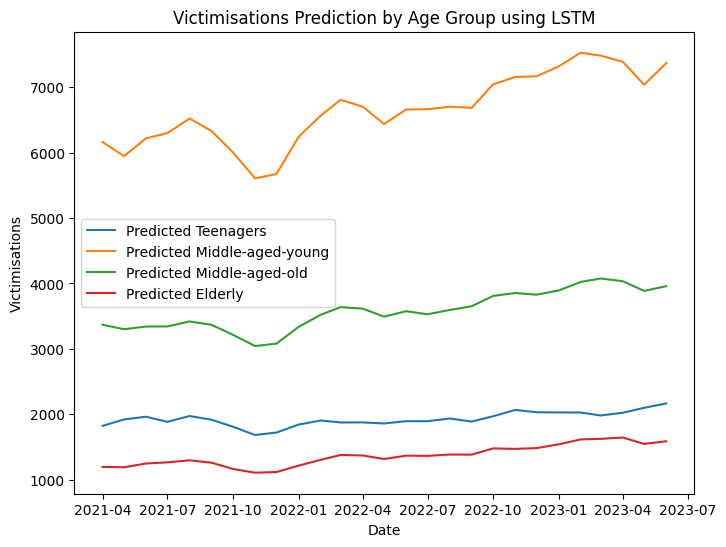

In [20]:
plt.figure(figsize=(8, 6))
for age_group in selected_age:
    age_data = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    age_data = age_data.sort_values('Date')

    train_data = age_data[age_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = age_data[age_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    time_axis = age_data['Date'][age_data['Date'] >= '2021-01-01'][window_size:]
    plt.plot(time_axis, predicted, label=f'Predicted {age_group}')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Age Group using LSTM')
plt.legend()
plt.show()


Epoch 1/200
14/14 [==============================] - 7s 87ms/step - loss: 0.2197 - val_loss: 0.1451
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0282 - val_loss: 0.0984
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0132 - val_loss: 0.1316
Epoch 4/200
14/14 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 0.1056
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0067 - val_loss: 0.1247
Epoch 6/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.1119
Epoch 7/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.1166
Epoch 8/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0041 - val_loss: 0.1227
Epoch 9/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.1220
Epoch 10/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.1248

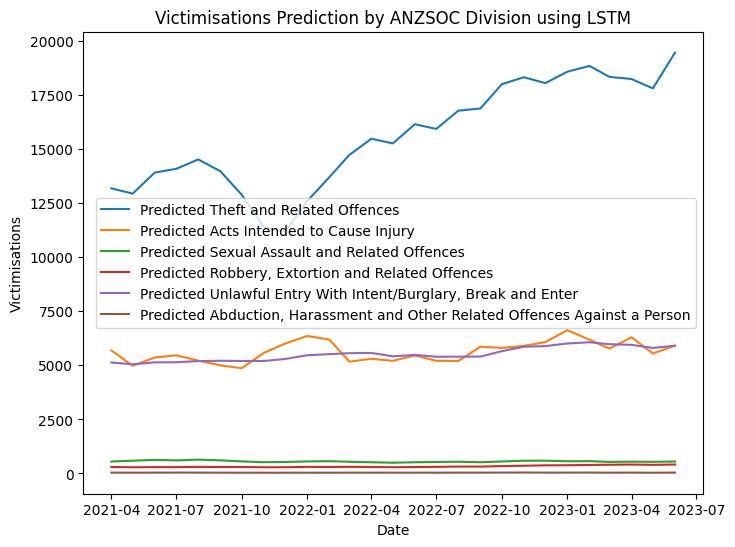

In [21]:
plt.figure(figsize=(8, 6))
for type_group in selected_type:
    type_data = crime_counts_by_type[crime_counts_by_type['ANZSOC Division'] == type_group]
    type_data = type_data.sort_values('Date')
    train_data = type_data[type_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = type_data[type_data['Date'] >= '2021-01-01']['Victimisations'].values
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))
    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)
    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    time_axis = type_data['Date'][type_data['Date'] >= '2021-01-01'][window_size:]
    plt.plot(time_axis, predicted, label=f'Predicted {type_group}')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by ANZSOC Division using LSTM')
plt.legend()
plt.show()

Epoch 1/200
14/14 [==============================] - 5s 83ms/step - loss: 0.2487 - val_loss: 0.0911
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0214 - val_loss: 0.0590
Epoch 3/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0131 - val_loss: 0.0897
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0687
Epoch 5/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0814
Epoch 6/200
14/14 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0703
Epoch 7/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0776
Epoch 8/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0722
Epoch 9/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.0787
Epoch 10/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0720

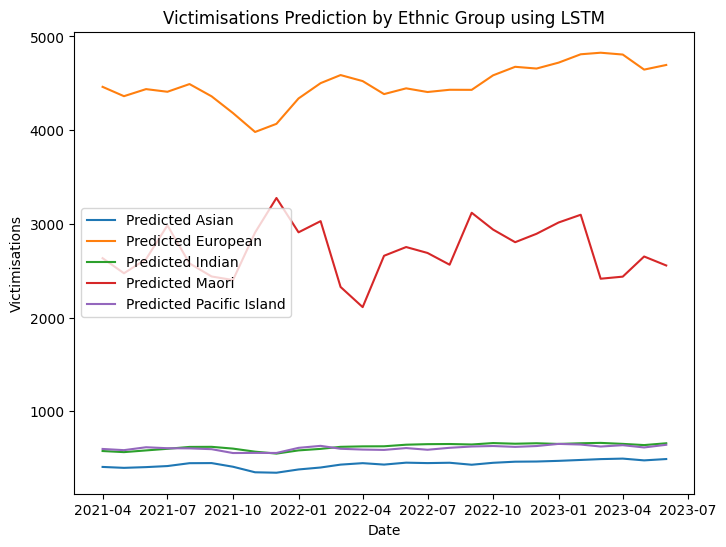

In [22]:
plt.figure(figsize=(8, 6))
for ethnicity in selected_ethnicities:
    ethnic_data = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    ethnic_data = ethnic_data.sort_values('Date')

    train_data = ethnic_data[ethnic_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = ethnic_data[ethnic_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)
    time_axis = ethnic_data['Date'][ethnic_data['Date'] >= '2021-01-01'][window_size:]
    plt.plot(time_axis, predicted, label=f'Predicted {ethnicity}')

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Ethnic Group using LSTM')
plt.legend()
plt.show()